<div dir="ltr" align="left">

# Project: Team Win Prediction for League of Legends

---

## Project Overview

The goal of this project is to build a **machine learning model** that predicts:

> Whether a League of Legends team will **win or lose**  
> based on its **team composition**, **players’ past performance**, and **team synergy**.

We use two data sources:
- **Kaggle dataset** (multiple CSV files)
- **Riot API dataset** (real player data)

---

## Data Files Used

| File | Description |
|------|--------------|
| **MatchTbl.csv** | Each row = a single match; includes `MatchId`, `GameDuration`, `QueueType`, `RankFk` |
| **SummonerMatchTbl.csv** | Each row = one player per match; includes `SummonerMatchId`, `SummonerFk`, `MatchFk`, `ChampionFk` |
| **MatchStatsTbl.csv** | Player-level stats within a match: `Lane`, `Win`, `Kills`, `Deaths`, `Assists`, `MinionsKilled`, `TotalGold` |
| **TeamMatchTbl.csv** | Each match with both teams’ champions: `BlueWin`, `B1Champ`…`B5Champ`, `R1Champ`…`R5Champ` |
| **lol_full_clean.csv (Riot)** | Player × Match dataset from Riot API with advanced metrics (`csPerMin`, `goldPerMin`, `dmgPerMin`, etc.) |

---

# 🔹 Step 1 – Collect Raw Player-Match Data

### Objective
Merge multiple Kaggle files into a single DataFrame representing one player per match.

---

### Inputs
- `matches_df`  
- `summoner_match_df`  
- `match_stats_df`

---

### Output
`raw_df` with:
`player_id, match_id, champion_id, role, win, kills, deaths, assists, MinionsKilled, total_gold, queue_type, rank_id, game_duration`

---

### Steps
1. Merge **SummonerMatchTbl** with **MatchStatsTbl** to connect each player with their match performance.  
2. Merge the result with **MatchTbl** to include overall match info.  
3. Rename columns for clarity and filter only `CLASSIC` queue type.  

---

### Code Example
```python
raw_df = (
    summoner_match_df
    .merge(match_stats_df, left_on="SummonerMatchId", right_on="SummonerMatchFk")
    .merge(matches_df, left_on="MatchFk", right_on="MatchId")
    .rename(columns={
        "SummonerFk": "player_id",
        "MatchFk": "match_id",
        "ChampionFk": "champion_id",
        "Lane": "role",
        "Win": "win",
        "TotalGold": "total_gold",
        "QueueType": "queue_type",
        "RankFk": "rank_id",
        "GameDuration": "game_duration",
    })
)
raw_df = raw_df[raw_df["queue_type"] == "CLASSIC"]






<div dir="ltr" align="left">

### 💡 Final Output
Each row in **`raw_df`** represents one player in one match,  
containing their individual stats, assigned role, and match information.

</div>

<div dir="ltr" align="left">

# 🔹 Step 2 – Build Player Role-Based Statistics

### Objective
Summarize each player's **historical performance** in every role they played.

---

### Input
`raw_df` (from Algorithm 1)

---

### Output
`player_role_stats` with:

| Column | Description |
|---------|--------------|
| `games_played` | number of games in that role |
| `wins` | total wins |
| `avg_kills`, `avg_deaths`, `avg_assists` | average combat stats |
| `avg_cs`, `avg_gold` | farming and gold performance |
| `winrate` | win ratio = wins ÷ games_played |

---

### Steps
1. Filter out rows without a valid role.  
2. Group by `(player_id, role)`.  
3. Aggregate key statistics:
   - `games_played` = unique matches
   - `wins` = sum of `win`
   - averages for `kills`, `deaths`, `assists`, `MinionsKilled`, and `total_gold`
4. Compute `winrate = wins / games_played`.

---

### Code Example
```python
player_role_stats = (
    raw_df.groupby(["player_id", "role"])
    .agg(
        games_played=("match_id", "nunique"),
        wins=("win", "sum"),
        avg_kills=("kills", "mean"),
        avg_deaths=("deaths", "mean"),
        avg_assists=("assists", "mean"),
        avg_cs=("MinionsKilled", "mean"),
        avg_gold=("total_gold", "mean")
    )
    .reset_index()
)
player_role_stats["winrate"] = player_role_stats["wins"] / player_role_stats["games_played"]





<div dir="ltr" align="left">

### 💡 Final Output
**`player_role_stats`** links each player to their role-based historical averages,  
for example:

> Player **1** as **SUPPORT**:  
> 10 games, 5 wins, average **1.3 kills**, **2.9 deaths**, **17.1 assists**, **winrate 50%**.

</div>


<div dir="ltr" align="left">

# 🔹 Step 3 – Construct Player-Team Training Table

### Objective
Connect each player with:
- Their **team side** (Blue/Red)
- **Team result** (Win/Loss)
- Their **historical stats** from `player_role_stats`

---

### Inputs
- `raw_df` (player-level)
- `team_df` (from TeamMatchTbl.csv)
- `player_role_stats`

---

### Output
`model_player_df` containing:
`player_id, match_id, champion_id, role, kills, deaths, assists, total_gold, MinionsKilled, team_side, team_win, hist_*`

---

### Steps
1. Merge `raw_df` and `team_df` by `match_id`.  
2. Assign `team_side`:
   - If champion in `[B1Champ..B5Champ]` → "Blue"
   - If champion in `[R1Champ..R5Champ]` → "Red"
3. Compute `team_win`:
   - If Blue → `team_win = BlueWin`
   - If Red → `team_win = 1 - BlueWin`
4. Merge with `player_role_stats` using (`player_id`, `role`).

---

### Code Example
```python
merged_df = raw_df.merge(team_df, on="match_id", how="left")

def get_team_side(row):
    blue = [row[f"B{i}Champ"] for i in range(1,6)]
    red  = [row[f"R{i}Champ"] for i in range(1,6)]
    if row["champion_id"] in blue: return "Blue"
    elif row["champion_id"] in red: return "Red"
    return "Unknown"

merged_df["team_side"] = merged_df.apply(get_team_side, axis=1)

def compute_team_win(row):
    if row["team_side"] == "Blue": return row["BlueWin"]
    elif row["team_side"] == "Red": return 1 - row["BlueWin"]
    return None

merged_df["team_win"] = merged_df.apply(compute_team_win, axis=1)

player_hist = player_role_stats.rename(columns=lambda x: "hist_" + x if x not in ["player_id", "role"] else x)
model_player_df = merged_df.merge(player_hist, on=["player_id", "role"], how="left")





<div dir="ltr" align="left">

### 💡 Final Output
Each row in **`model_player_df`** represents:

- One player in a specific match  
- Their performance metrics (kills, deaths, assists, gold, CS)  
- Their team side (Blue/Red) and match result (Win/Loss)  
- Their historical averages for that role  

</div>


<div dir="ltr" align="left">

# 🔹 Step 4 – Create Team-Level Aggregated Dataset

### Objective
Convert player-level data to **team-level** by averaging all five players’ stats,  
then calculate **team synergy** metrics.

---

### Input
`model_player_df`

---

### Output
- `team_model_df`: team averages before synergy
- `kaggle_team_full_df`: includes synergy metrics

---

### Steps
1. Group by `(match_id, team_side)`  
2. Aggregate team averages:
   - kills, deaths, assists, MinionsKilled, total_gold  
   - historical averages (winrate, kills, deaths, assists)
3. Compute **synergy features**:
   - `syn_kills_mean/std`, `syn_assists_mean/std`, `syn_deaths_mean/std`
   - `syn_role_entropy`, `syn_role_imbalance`
   - `syn_gold_share_std/max`, `syn_kill_share_std/max`, etc.

---

### 💡 Final Output
Each row in `kaggle_team_full_df` = one team in one match,  
including both performance and synergy indicators.

</div>


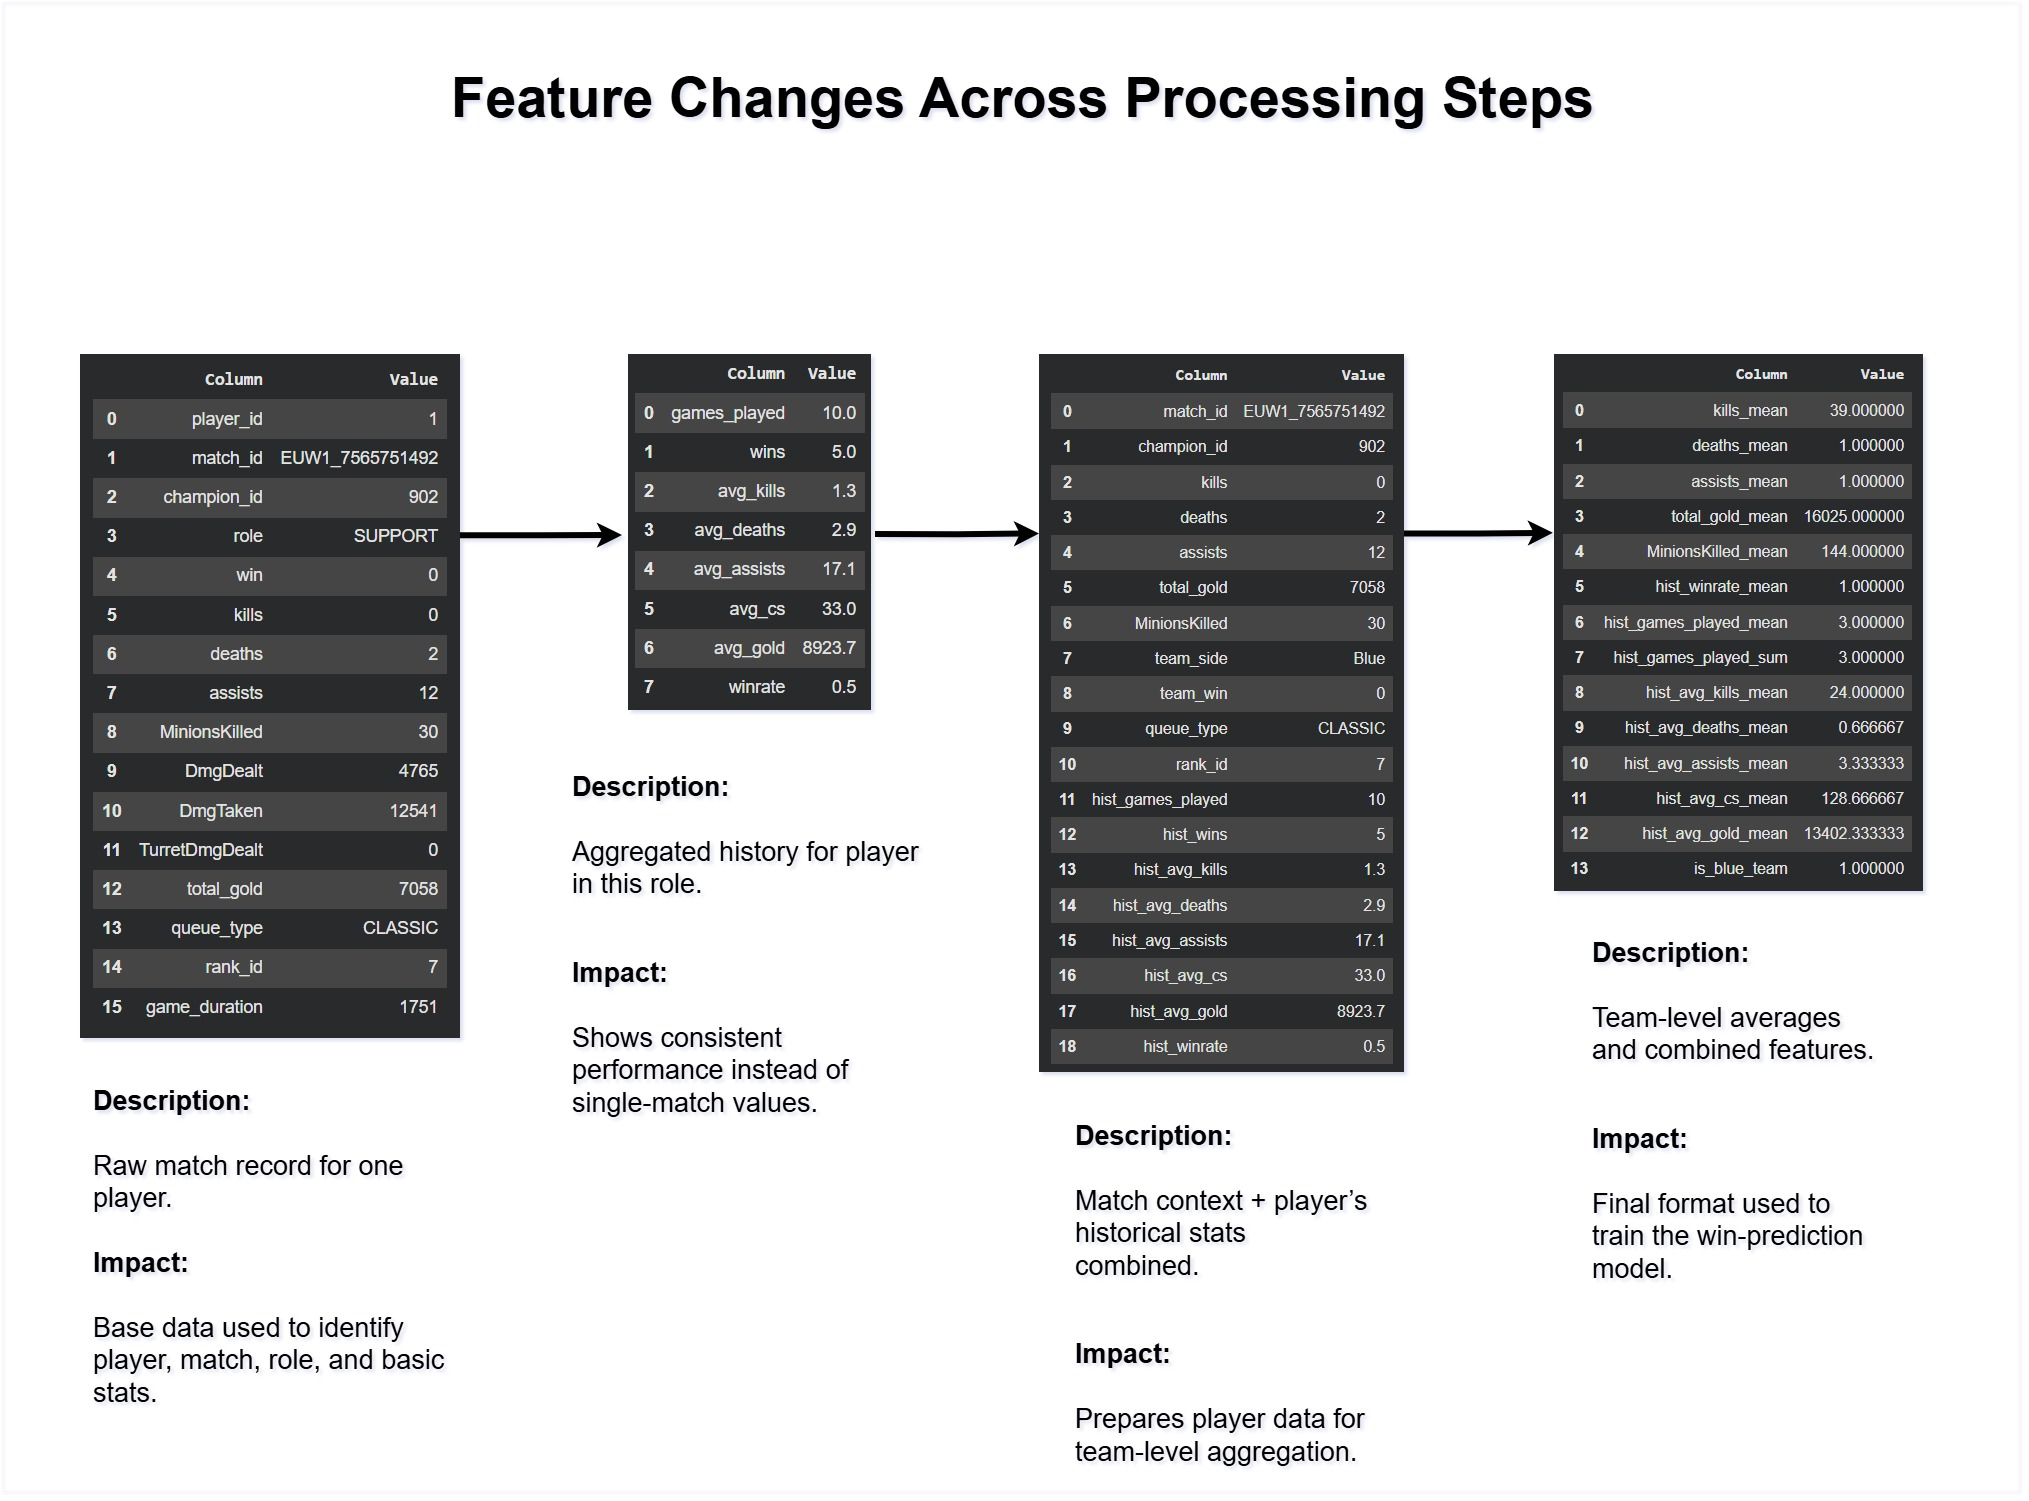

<div dir="ltr" align="left">

# 🔹 Step 5 – Building `riot_team_full_df` (Riot Dataset)

### Objective
Replicate the Kaggle preprocessing on Riot API data to create team-level features with synergy.

---

### Input
`lol_full_clean.csv` (Riot data)

---

### Output
`riot_team_full_df`  
with averages of team performance (`kills_mean`, `deaths_mean`, `assists_mean`, etc.)  
and synergy metrics (`syn_gold_share_std`, `syn_dmg_share_max`, etc.)

---

### 💡 Final Output
Each row = one team per match,  
containing their full feature set consistent with Kaggle data structure.

</div>


<div dir="ltr" align="left">

# 🔹 Step 6 – Building `full_train_df` and Training the Model

### Objective
Combine Kaggle + Riot data and train a **RandomForestClassifier (v5)** to predict `team_win`.

---

### Inputs
- `kaggle_team_full_df`
- `riot_team_full_df`

---

### Outputs
- `full_train_df`
- Trained `rf_model_v5`
- Evaluation metrics (Accuracy, Classification Report, Confusion Matrix)

---

### Steps

```python
target_col = "team_win"

# unify features
kaggle_model_df = kaggle_team_full_df[[target_col] + feature_cols_v5].copy()
riot_model_df   = riot_team_full_df[[target_col] + feature_cols_v5].copy()

kaggle_model_df["dataset_source"] = 0
riot_model_df["dataset_source"]   = 1

full_train_df = pd.concat([kaggle_model_df, riot_model_df], ignore_index=True)

# split X/y
X = full_train_df[feature_cols_v5]
y = full_train_df[target_col]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# train model
from sklearn.ensemble import RandomForestClassifier
rf_model_v5 = RandomForestClassifier(n_estimators=500, min_samples_split=4, min_samples_leaf=2, random_state=42, n_jobs=-1, class_weight="balanced_subsample")
rf_model_v5.fit(X_train, y_train)

# evaluate
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
y_pred = rf_model_v5.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("✅ Test Accuracy:", round(acc, 4))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))




<div dir="ltr" align="left">

### 💡 Final Output
During training, the model learns relationships between **team statistics** and the target **`team_win`**.  

During prediction:
- `predict(X_new)` → returns **0** (loss) or **1** (win)  
- `predict_proba(X_new)` → returns the **win probability** (e.g., 0.68 = 68%)

</div>


ٍ<div dir="ltr" align="left">

# 🔹 Step 7 – Testing the Model on Real Players (Riot API)

### Objective
Use the trained model on **real players** fetched via Riot API  
to simulate a team and predict their win probability.

---

### Inputs
- List of 5 players (`gameName`, `tagLine`)
- Riot API endpoints  
- `rf_model_v5` (trained model)
- `feature_cols_v5`

---

### Outputs
- Player-level data from API
- Team-level aggregated row (same structure as training)
- `proba_win`, `pred_win`

---

### Steps
1. Fetch each player's data:
   - Get `puuid` via `GET /riot/account/v1/accounts/by-riot-id/{gameName}/{tagLine}`
   - Fetch recent `match_ids`
   - Extract per-match stats: kills, deaths, assists, cs, gold, damage, shares, win

2. Aggregate each player's performance (like Algorithm 2).  
3. Combine the 5 players into one team DataFrame.  
4. Compute synergy using same logic (`build_team_synergy_from_players`).  
5. Ensure all `feature_cols_v5` exist and align with training data.  
6. Predict:

```python
X_new = team_features_df[feature_cols_v5].values.reshape(1, -1)
proba_win = rf_model_v5.predict_proba(X_new)[0, 1]
pred_win  = rf_model_v5.predict(X_new)[0]


<div dir="ltr" align="left">

### 💡 Interpretation
If the model outputs:

> **Predicted win probability: 68% – Prediction: Win ✅**

That means:

- The **team composition** is balanced,  
- The **players’ historical performance** is strong,  
- The **roles and resources** are well distributed,  

Therefore, the data indicates that teams with similar compositions **tend to win more often**.

</div>
